## Indice

1. [Bag-of-Words con TF-IDF / BM25]()  
2. [PageRank e segnali di autorità]()  
3. [LDA – Latent Dirichlet Allocation]()  
4. [Word Embeddings statici]()  
5. [BERT ed embeddings contestuali]()  
6. [Dense Retrieval (DPR)]()  
7. [BGE-M3 (2024)]()  
8. [RAG – Retrieval Augmented Generation]()

## Dataset

<p style="text-align:center;">
  <img src="img/data_set.png" alt="bm25" width="700">
</p>

In [1]:
import numpy as np
from nltk.corpus import stopwords
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
import time
from rank_bm25 import BM25Okapi
from sklearn.preprocessing import normalize

In [2]:
from data_io import load_paragraphs, load_questions
from metrics import eval_retriever

df_para = load_paragraphs()
df_q_sc = load_questions()

Loaded 14049 paragraphs in 'sc'
Loaded 2677 questions


In [3]:
import nltk
nltk.download("punkt")
nltk.download("punkt_tab")
nltk.download("stopwords")
STOP_IT = set(stopwords.words("italian")) # non ho stopword in sardo

def preprocess(text: str) -> list[str]:
    """Light tokenisation + lower-casing + stop-word removal.
    
    Args:
        text: Raw input string.
    
    Returns:
        List of tokens.
    """
    tokens = word_tokenize(text.lower())
    return [t for t in tokens if t.isalpha() and t not in STOP_IT]

[nltk_data] Downloading package punkt to /home/matmat/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/matmat/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /home/matmat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
df_para_dedup = df_para.drop_duplicates(subset="text").reset_index(drop=True)
corpus = df_para_dedup["text"]
token_corpus = [preprocess(t) for t in tqdm(corpus, desc="Tokenising")]

Tokenising:   5%|▌         | 251/4772 [00:00<00:04, 1011.61it/s]

Tokenising: 100%|██████████| 4772/4772 [00:02<00:00, 2160.34it/s]


## Tf-idf

<p style="text-align:center;">
  <img src="img/tf-idf-formula.png" alt="bm25" width="300">
</p>

In [5]:
tfidf_vectorizer = TfidfVectorizer(
    tokenizer=lambda x: x,  # pass pre-tokenised list
    lowercase=False,
    token_pattern=None,
    min_df=2,
)
t0 = time.time()
X_tfidf = tfidf_vectorizer.fit_transform(token_corpus)
X_tfidf = normalize(X_tfidf) 
index_time_tfidf = time.time() - t0
print(f"TF-IDF index built in {index_time_tfidf:.1f}s, shape={X_tfidf.shape}")

TF-IDF index built in 0.2s, shape=(4772, 13078)


In [6]:
def tfidf_retrieve(query: str, k: int = 10) -> list[str]:
    """Return top-k page titles via TF-IDF cosine similarity."""
    q_vec = normalize(tfidf_vectorizer.transform([preprocess(query)]))
    scores = (q_vec @ X_tfidf.T).toarray().ravel()
    idx = np.argpartition(scores, -k)[-k:]
    idx = idx[np.argsort(scores[idx])[::-1]]
    return df_para_dedup["page_cf"].iloc[idx].tolist()

In [7]:
t0 = time.time()
tfidf_scores = eval_retriever(tfidf_retrieve, df_q_sc, k=10)
dt = (time.time() - t0) / len(df_q_sc)
print(
    f"R@10={tfidf_scores['recall@k']:.3f}  "
    f"MRR={tfidf_scores['mrr']:.3f}  "
    f"avg query {dt*1000:.1f} ms"
)

R@10=0.547  MRR=0.406  avg query 3.0 ms


## BM25

<p style="text-align:center;">
  <img src="img/bm25_flowchart.png" alt="bm25" width="500">
</p>

In [8]:
t0 = time.time()
bm25 = BM25Okapi(token_corpus)
index_time_bm25 = time.time() - t0
print(f"BM25 index built in {index_time_bm25:.1f}s")

BM25 index built in 0.1s


In [9]:
def bm25_retrieve(query: str, k: int = 10) -> list[str]:
    """Return top-k page titles using BM25."""
    scores = bm25.get_scores(preprocess(query))
    idx    = np.argpartition(scores, -k)[-k:]
    idx    = idx[np.argsort(scores[idx])[::-1]]
    return df_para_dedup["page_cf"].iloc[idx].tolist()

In [10]:
t0 = time.time()
bm25_scores = eval_retriever(bm25_retrieve, df_q_sc, k=10)
dt = (time.time() - t0) / len(df_q_sc)
print(f"R@10={bm25_scores['recall@k']:.3f}  MRR={bm25_scores['mrr']:.3f} | "f"avg query {dt*1000:.1f} ms")

R@10=0.570  MRR=0.439 | avg query 8.5 ms


## PageRank

In [11]:
from pathlib import Path
import urllib.parse as ul
import pickle, re
from bs4 import BeautifulSoup
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
CORPUS_DIR = Path("corpus/sc")
GRAPH_PATH = Path("graph_pagelevel.pkl")
PR_PATH    = Path("pagerank_pagelevel.pkl")

SKIP_NS   = ("/wiki/File:", "/wiki/Category:", "/wiki/Special:",
             "/wiki/Help:", "/wiki/Talk:", "/wiki/Template:")
HREF_RE   = re.compile(r"^/wiki/[^:#]*$")

In [13]:
def iter_html_files(dir_: Path):
    """Yield every *.html under dir_."""
    yield from dir_.glob("*.html")


def slug_from_file(fp: Path) -> str:
    """Return Wiki slug after the first '_' (numeric prefix removed)."""
    return fp.stem.split("_", 1)[1]


def title_from_slug(slug: str) -> str:
    return ul.unquote(slug).replace("_", " ")


def extract_link_slugs(html: str) -> set[str]:
    """Return set of Wiki slugs linked inside *html*."""
    soup = BeautifulSoup(html, "lxml")
    out = set()
    for a in soup.select("a[href]"):
        href = a["href"]
        if href.startswith(SKIP_NS) or not HREF_RE.match(href):
            continue
        out.add(href.split("/wiki/")[1])
    return out

In [14]:
def build_graph(corpus_dir: Path) -> nx.DiGraph:
    """Return DiGraph where each node is a *page* (aggregates its files)."""
    # 1) group files by page
    page2files = {}
    for fp in iter_html_files(corpus_dir):
        slug  = slug_from_file(fp)
        title = title_from_slug(slug)
        page2files.setdefault(title, []).append(fp)

    # 2) build graph
    g = nx.DiGraph()
    g.add_nodes_from(page2files)          # all pages, even isolated

    for src, files in page2files.items():
        linked_slugs = set()
        for fp in files:
            html = fp.read_text(encoding="utf-8", errors="ignore")
            linked_slugs |= extract_link_slugs(html)

        for slug in linked_slugs:
            dst = title_from_slug(slug)
            if dst in g and dst != src:
                g.add_edge(src, dst)

    return g

In [15]:
G = build_graph(CORPUS_DIR)
print(f"Nodes: {G.number_of_nodes():,}  |  Edges: {G.number_of_edges():,}")

PR = nx.pagerank(G)

with open(GRAPH_PATH, "wb") as f:
    pickle.dump(G, f)
with open(PR_PATH, "wb") as f:
    pickle.dump(PR, f)

Nodes: 981  |  Edges: 7,502


In [16]:
GRAPH_PATH = Path("graph_pagelevel.pkl")
PR_PATH    = Path("pagerank_pagelevel.pkl")
TITLE_COL  = "page_cf"

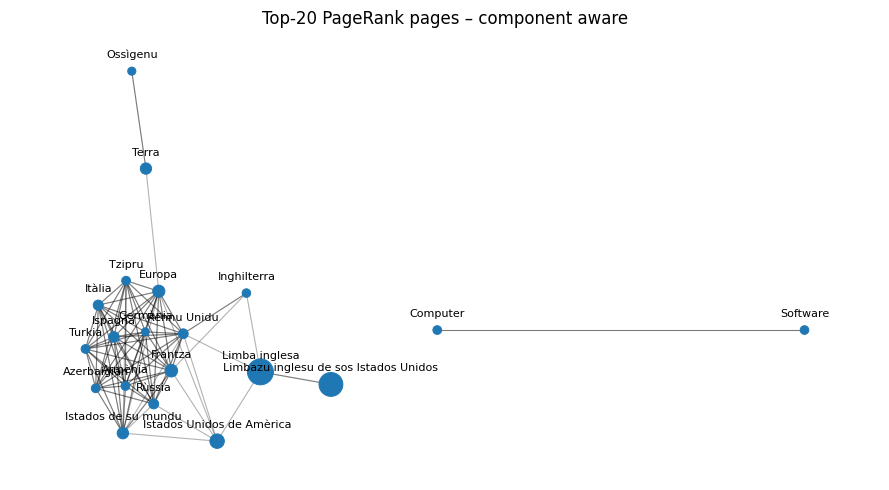

In [17]:
import pickle, networkx as nx, matplotlib.pyplot as plt
from pathlib import Path
from itertools import count

# ── load ───────────────────────────────────────────────────────────────
G  = pickle.load(open("graph_pagelevel.pkl", "rb"))
PR = pickle.load(open("pagerank_pagelevel.pkl", "rb"))

TOP_N      = 20
top_nodes  = sorted(PR, key=PR.get, reverse=True)[:TOP_N]
H          = G.subgraph(top_nodes).copy()

sub_pos = {}
x_shift = 0
for comp_id, comp in enumerate(nx.connected_components(H.to_undirected())):
    sub = H.subgraph(comp)
    # kamada-kawai inside the component
    pos_sub = nx.kamada_kawai_layout(sub)
    # shift component on x-axis so clusters don’t overlap
    for n, (x, y) in pos_sub.items():
        sub_pos[n] = (x + x_shift, y)
    # space out for next component
    x_shift += 2.5

fig, ax = plt.subplots(figsize=(9, 5))
nx.draw_networkx_edges(H, sub_pos, alpha=0.3, width=0.8, arrows=False)
nx.draw_networkx_nodes(
    H, sub_pos,
    node_size=[6000 * PR[n] for n in H],
    linewidths=0.7,
)
# label offset: small vertical shift
for n, (x, y) in sub_pos.items():
    ax.text(x, y + 0.05, n, fontsize=8, ha="center")

ax.set_title(f"Top-{TOP_N} PageRank pages – component aware")
ax.axis("off")
plt.tight_layout()
plt.show()

## Embedding Statici

<p style="text-align:center;">
  <img src="img/word2_vec.png" alt="bm25" width="700">
</p>

In [18]:
import math
from gensim.models.fasttext import load_facebook_vectors
from collections import Counter
import faiss

In [19]:
# mkdir -p models
# wget -P models https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.sc.300.bin.gz
# gunzip models/cc.sc.300.bin.gz

# mkdir -p models
# wget -P models https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz
# gunzip models/cc.en.300.bin.gz

In [20]:
FT_PATH = "models/cc.sc.300.bin"
ft = load_facebook_vectors(FT_PATH)
EMB_DIM = ft.vector_size

In [21]:
df_counts = Counter()
for toks in token_corpus:
    df_counts.update(set(toks))
N_DOCS = len(token_corpus)

def idf(token: str) -> float:
    return math.log((N_DOCS + 1) / (df_counts.get(token, 0) + 1))

In [22]:
def sent_vec(tokens: list[str]) -> np.ndarray:
    """Average FastText vectors (IDF-weighted)."""
    vsum, wsum = np.zeros(EMB_DIM), 0.0
    for tok in tokens:
        vec = ft.get_vector(tok)        # always returns vector (sub-word)
        w = idf(tok)
        vsum += vec * w
        wsum += w
    return vsum / wsum if wsum else vsum

In [23]:
para_vecs = np.vstack([sent_vec(t) for t in tqdm(token_corpus)])
para_vecs = np.ascontiguousarray(para_vecs, dtype=np.float32)
faiss.normalize_L2(para_vecs)

index_ft = faiss.IndexFlatIP(EMB_DIM)
index_ft.add(para_vecs)

100%|██████████| 4772/4772 [00:02<00:00, 2383.97it/s]


In [24]:
def dense_retrieve(query: str, k: int = 10) -> list[str]:
    toks = preprocess(query)
    q_vec = sent_vec(toks).astype(np.float32)
    q_vec = np.ascontiguousarray(q_vec.reshape(1, -1))
    faiss.normalize_L2(q_vec)
    _, I = index_ft.search(q_vec, k)
    return df_para_dedup["page_cf"].iloc[I[0]].tolist()

In [25]:
t0 = time.time()
dense_scores = eval_retriever(dense_retrieve, df_q_sc, k=10)
dt = (time.time() - t0) / len(df_q_sc)
print(f"R@10={dense_scores['recall@k']:.3f}  MRR={dense_scores['mrr']:.3f} | "f"avg query {dt*1000:.1f} ms")

R@10=0.263  MRR=0.210 | avg query 4.6 ms


## Sentence-Bert

<p style="text-align:center;">
  <img src="img/Bert_.PNG" alt="bm25" width="250">
</p>

In [26]:
from pathlib import Path
from sentence_transformers import SentenceTransformer
import time
import numpy as np
import faiss
import joblib

/home/matmat/sardu/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
INDEX_DIR = Path("indices")
INDEX_DIR.mkdir(exist_ok=True)
model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)

In [28]:
t0 = time.time()
para_vecs = model.encode(
    corpus,
    batch_size=64,
    show_progress_bar=True,
    normalize_embeddings=True,   # L2-normalizes
    convert_to_numpy=True
).astype("float32")
print(f"Embedding done in {(time.time() - t0) / 60:.1f} min")

Batches: 100%|██████████| 75/75 [00:20<00:00,  3.70it/s]

Embedding done in 0.3 min


In [29]:
DIM = para_vecs.shape[1]
index_sbert = faiss.IndexFlatIP(DIM)
index_sbert.add(para_vecs)
print(f"Index size: {index_sbert.ntotal} vectors")

Index size: 4772 vectors


In [30]:
def sbert_retrieve(query: str, k: int = 10) -> list[str]:
    q_vec = model.encode(
        [query],
        normalize_embeddings=True,
        convert_to_numpy=True
    ).astype("float32")
    _, indices = index_sbert.search(q_vec, k)
    return df_para_dedup.iloc[indices[0]]["page_cf"].tolist()

In [31]:
t0 = time.time()
sbert_scores = eval_retriever(sbert_retrieve, df_q_sc, k=10)
dt = (time.time() - t0) / len(df_q_sc)
print(f"R@10={sbert_scores['recall@k']:.3f}  MRR={sbert_scores['mrr']:.3f} | "f"avg query {dt*1000:.1f} ms")

R@10=0.511  MRR=0.403 | avg query 17.0 ms


In [32]:
faiss.write_index(index_sbert, str(INDEX_DIR / "sbert.index"))

meta = df_para[["page_cf", "page_title", "text"]].to_dict("records")
joblib.dump(meta, INDEX_DIR / "meta_sbert.pkl")

print("✅ SBERT index and metadata saved in", INDEX_DIR.resolve())

✅ SBERT index and metadata saved in /home/matmat/sardu/indices


In [33]:
import faiss, numpy as np, joblib, pandas as pd
from sentence_transformers import SentenceTransformer

INDEX_DIR = Path("indices")

index_sbert = faiss.read_index(str(INDEX_DIR / "sbert.index"))
meta        = joblib.load(INDEX_DIR / "meta_sbert.pkl")
model       = SentenceTransformer(model_name)

def embed_q(text: str):
    return model.encode([text], normalize_embeddings=True).astype("float32")

In [34]:
query_vec = embed_q("cales mare si b'hat a circundare Dubai")
_, hits = index_sbert.search(query_vec.reshape(1, -1), 3)
pd.DataFrame(meta).iloc[hits[0]]

,page_cf,page_title,text
1072,gherra de su golfu,Gherra de su Golfu,A pagas oras de s'invasione de su 2 austu 1990...
1069,gherra de su golfu,Gherra de su Golfu,Sa prima gherra de su Golfu est istada fintzas...
1085,gherra de su golfu,Gherra de su Golfu,"A sas 3, deghe stealth F-117 Nighthawk in suta..."


## Bge-m3

<p style="text-align:center;">
  <img src="img/bge_ar.png" alt="bm25" width="450">
</p>

In [35]:
from pathlib import Path
import time, numpy as np, pandas as pd, faiss, joblib
from tqdm import tqdm
from FlagEmbedding import BGEM3FlagModel

INDEX_DIR = Path("indices")

In [36]:
model = BGEM3FlagModel("BAAI/bge-m3", device="cuda", use_fp16=True)
BATCH_SIZE = 16

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 116185.71it/s]


In [37]:
t0 = time.time()
embeddings = model.encode(
    corpus.tolist(),
    batch_size=BATCH_SIZE,
    convert_to_numpy=True,
)['dense_vecs'].astype("float32")
print(f"Embedding done in {(time.time() - t0)/60:.1f} min")

pre tokenize: 100%|██████████| 299/299 [00:00<00:00, 357.92it/s]
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Inference Embeddings: 100%|██████████| 299/299 [06:05<00:00,  1.22s/it]

Embedding done in 6.4 min


In [38]:
DIM = embeddings.shape[1]
index_bge = faiss.IndexFlatIP(DIM)
index_bge.add(embeddings)
print(f"Index size: {index_bge.ntotal} vectors")

Index size: 4772 vectors


In [39]:
def bge_m3_retrieve(query: str, k: int = 10) -> list[str]:
    q_vec = model.encode(
        [query],
        convert_to_numpy=True
    )['dense_vecs'].astype("float32")
    _, indices = index_bge.search(q_vec, k)
    return df_para_dedup.iloc[indices[0]]["page_cf"].tolist()

In [40]:
t0 = time.time()
bge_scores = eval_retriever(bge_m3_retrieve, df_q_sc, k=10)
dt = (time.time() - t0) / len(df_q_sc)
print(f"R@10={bge_scores['recall@k']:.3f}  MRR={bge_scores['mrr']:.3f} | "f"avg query {dt*1000:.1f} ms")

R@10=0.854  MRR=0.713 | avg query 80.3 ms


In [52]:
faiss.write_index(index_bge, str(INDEX_DIR / "bge.index"))

meta = df_para[["page_cf", "page_title", "text"]].to_dict("records")
joblib.dump(meta, INDEX_DIR / "meta_bge.pkl")

print("✅ BGE index and metadata saved in", INDEX_DIR.resolve())

✅ BGE index and metadata saved in /home/matmat/sardu/indices


In [53]:
import faiss, numpy as np, joblib, pandas as pd
from FlagEmbedding import BGEM3FlagModel

INDEX_DIR = Path("indices")

index_bge = faiss.read_index(str(INDEX_DIR / "bge.index"))
meta        = joblib.load(INDEX_DIR / "meta_bge.pkl")
model       = BGEM3FlagModel("BAAI/bge-m3", device="cuda", use_fp16=True)

def embed_q(text: str):
    return model.encode([text], convert_to_numpy=True)['dense_vecs'].astype("float32")

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 66859.26it/s]


In [ ]:
query_vec = embed_q("cali esti su logu prus abbaxiu de sa Terra")
_, hits = index_bge.search(query_vec.reshape(1, -1), 3) 
pd.DataFrame(meta).iloc[hits[0]]

,page_cf,page_title,text
2385,giapone,Giapone,Coordinadas : 35°N 136°E ﻿ / ﻿ 35°N 136°E 35; 136
233,acòrdios de münchen,Acòrdios de München,"Segundu sa retòrica de sa propaganda nazista ,..."
2861,su sennore de sos aneddos,Su Sennore de sos Aneddos,Tolkien at fintzas imbentadu pro su contu duas...


## Reranker

<p style="text-align:center;">
  <img src="img/bi.PNG" alt="bm25" width="450">
</p>

In [44]:
from pathlib import Path
import faiss, joblib, numpy as np
from FlagEmbedding import BGEM3FlagModel, FlagReranker
import pandas as pd
import torch, gc

INDEX_DIR = Path("indices")

In [45]:
index  = faiss.read_index(str(INDEX_DIR / "bge.index"))
meta   = joblib.load(INDEX_DIR / "meta_bge.pkl")  # list[dict]
df_meta = pd.DataFrame(meta)                      # quick look-up

encoder = BGEM3FlagModel(
    "BAAI/bge-m3",
    device="cuda",
    use_fp16=True,       # fp16 inutile su CPU
)

reranker = FlagReranker(
    "BAAI/bge-reranker-v2-m3",
    device="cuda" if torch.cuda.is_available() else "cpu",
    use_fp16=True,
)

Fetching 30 files: 100%|██████████| 30/30 [00:00<00:00, 83220.32it/s]


In [46]:
def bge_m3_rr_retrieve(query: str, k: int = 10, n_probe: int = 50,  rr_bs: int = 64) -> list[str]:
    q_vec = encoder.encode([query], convert_to_numpy=True)["dense_vecs"]\
                  .astype(np.float32)
    _, idx = index.search(q_vec, n_probe)

    cand_df = df_meta.iloc[idx[0]]
    pairs = [[query, t] for t in cand_df["text"].tolist()]

    scores = reranker.compute_score(pairs,
                                    batch_size=rr_bs,
                                    normalize=True)

    top = np.argsort(scores)[::-1][:k]
    return cand_df.iloc[top]["page_cf"].tolist()

In [47]:
# t0 = time.time()
# rbge_scores = eval_retriever(bge_m3_rr_retrieve, df_q_sc, k=10)
# dt = (time.time() - t0) / len(df_q_sc)
# print(f"R@10={rbge_scores['recall@k']:.3f}  MRR={rbge_scores['mrr']:.3f} | "f"avg query {dt*1000:.1f} ms")

## Rag

<p style="text-align:center;">
  <img src="img/rag.png" alt="bm25" width="450">
</p>

In [60]:
from openai import OpenAI
KEY_FILE = Path(".openai_key")

api_key = KEY_FILE.read_text().strip()
client = OpenAI(api_key=api_key)

In [ ]:
def _generate(question: str, context: str) -> str:
    """Generate an answer using OpenAI ChatCompletion."""
    messages = [
        {
            "role": "system",
            "content": (
                "You are a concise, helpful assistant. "
                "Answer using only the information in the context. "
                "The user does not need to know that there is a context. "
                "If unsure, say it "
                "You must respond in Sardinian. "
            ),
        },
        {
            "role": "user",
            "content": f"Context:\n\"\"\"\n{context}\n\"\"\"\n\nQuestion: {question}",
        },
    ]
    resp = client.chat.completions.create(
        model="gpt-4o-mini",
        messages=messages,
        temperature=0.2,
        max_tokens=512,
    )
    return resp.choices[0].message.content.strip()


In [62]:
def answer_user_query(question: str, k: int = 3) -> str:
    q_vec = embed_q(question)
    _, hit_idx = index_bge.search(q_vec, k)       # shape (1, k)
    texts = [meta[i]["text"] for i in hit_idx[0]]
    context = "\n\n---\n\n".join(texts)
    return _generate(question, context)

In [64]:
q = "Qual è continente più a Sud della Terra"
print(answer_user_query(q))

Non so.


| Metodo     | Recall@10 | MRR     | Δ Recall vs BM25 | ms/it |
|------------|-----------|---------|------------------|-------|
| TFIDF      | 0.547     | 0.406   | – 0.023           | 3.9   |
| BM25       | 0.570     | 0.439   | X                 | 10.0  |
| FASTEXT    | 0.263     | 0.210   | – 0.307           | 4.2   |
| SBERT      | 0.511     | 0.403   | – 0.059           | 19.2  |
| **BGE-M3** | **0.854** | **0.713** | **+0.284**      | 84.6  |

## Now...

<p style="text-align:center;">
  <img src="img/bge_vs_all.png" alt="bm25" width="450">
</p>

| Modello                                 | Parametri (M) | Efficienza embedding    | nDCG\@10 (BEIR) | Caratteristica distintiva                                          |
| --------------------------------------- | ------------- | ----------------------- | --------------- | ------------------------------------------------------------------ |
| Alibaba-NLP/gte-multilingual-base       | 305           | veloce                  | 51.1            | Encoder-only (contesto 8192, embedding elastico/sparso)            |
| nomic-ai/nomic-embed-text-v2-moe        | 475 (305)          | media (MoE 8 esperti)   | 52.9            | Mixture-of-Experts (8 esperti) con embedding Matryoshka            |
| Snowflake/snowflake-arctic-embed-l-v2.0 | 568           | veloce                  | 55.6            | BGE M3-RetroMAE (contesto 8192) con Matryoshka (compressione 128B) |
| jinaai/jina-embeddings-v3               | 570           | media (multi-task LoRA) | 55.8            | Multi-task con LoRA e Matryoshka (dim. flessibile)                 |